In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score, roc_curve, auc, precision_recall_fscore_support
from sklearn.feature_extraction import DictVectorizer

from IPython.display import display
import pickle

from ydata_profiling import ProfileReport

Data Preparation

In [3]:
df = pd.read_csv('datasets/borrower_data.csv')

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [5]:
emp_length_median = df['person_emp_length'].median()

df['person_emp_length'] = df['person_emp_length'].fillna(emp_length_median)

blank_int_rate_indices = df[df['loan_int_rate'].isna()].index

df.drop(blank_int_rate_indices, inplace=True)

df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [6]:
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']

categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade']

target_col = 'loan_status'

Exploratory Data Analysis

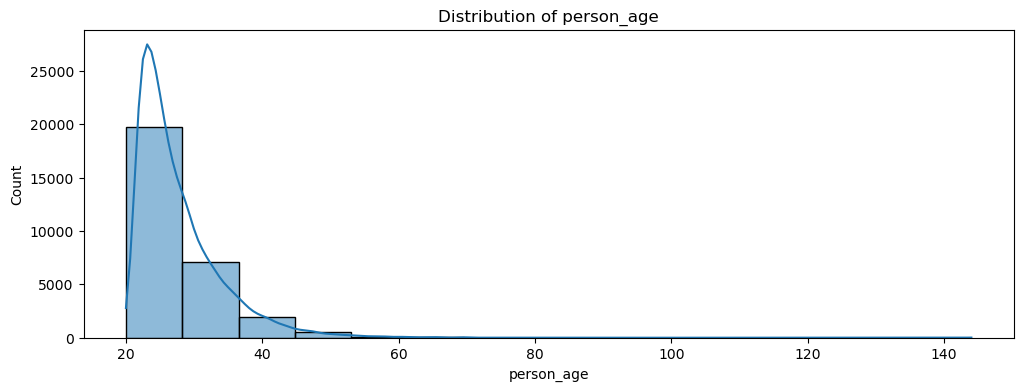

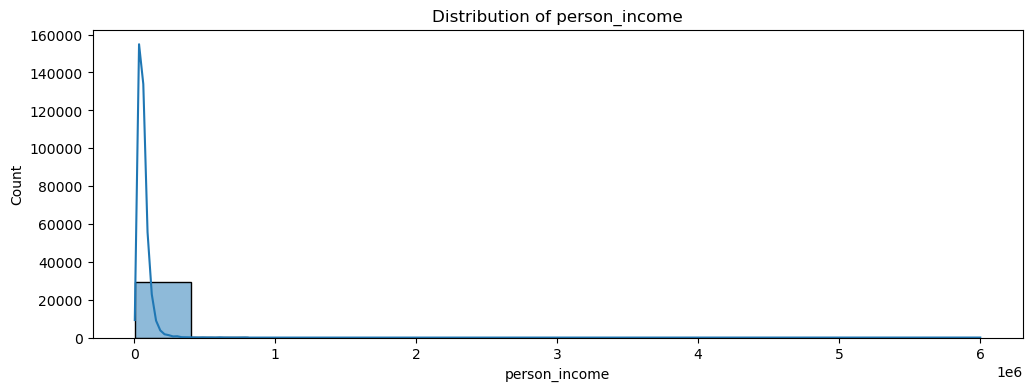

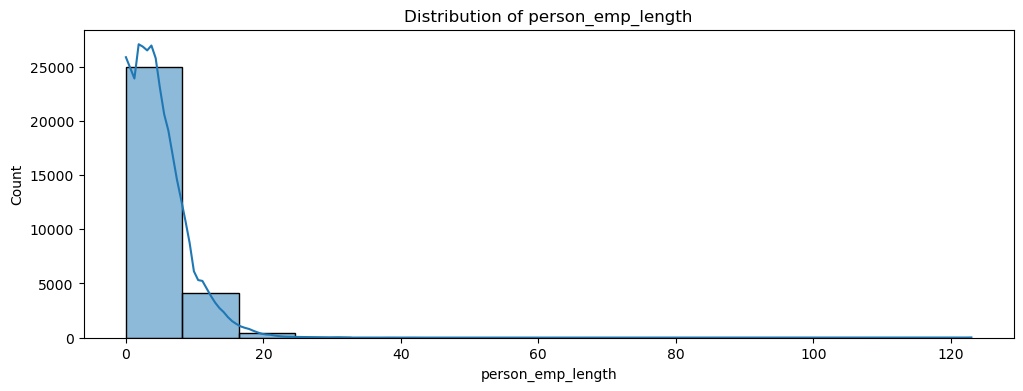

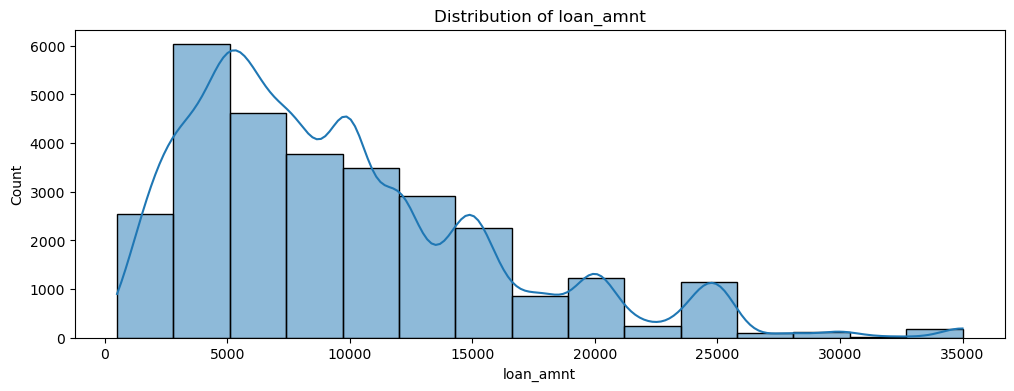

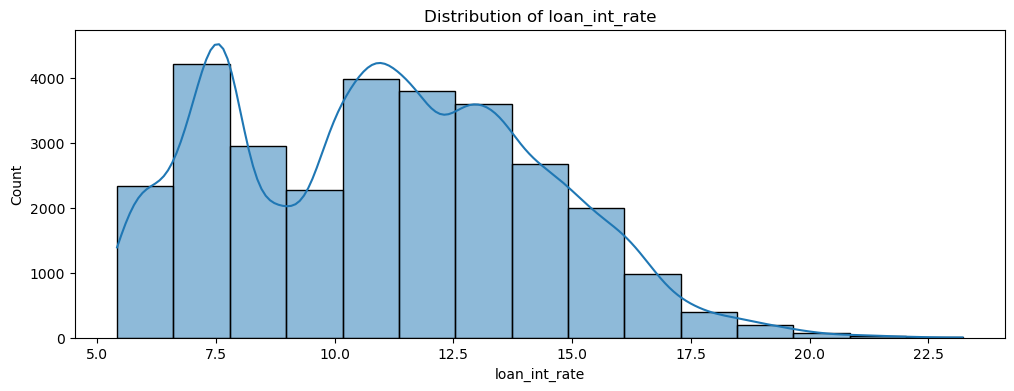

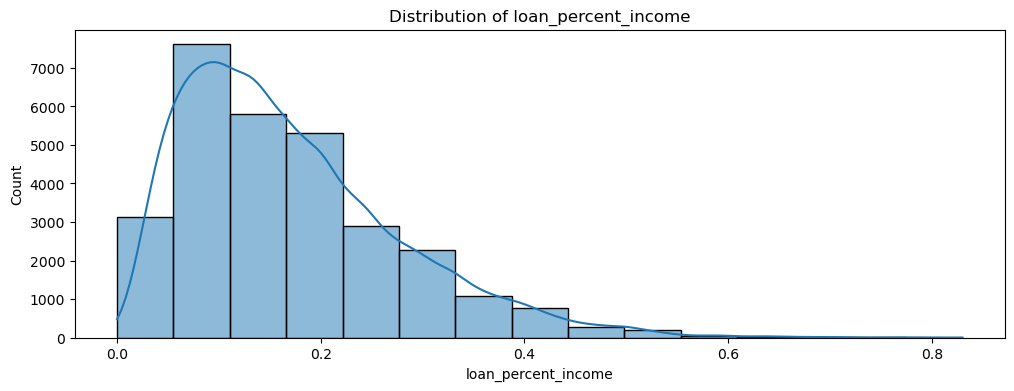

In [7]:
for col in numerical_cols:
    plt.figure(figsize=(12,4))
    sns.histplot(df[col], bins=15, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


Univariate Analysis

In [8]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Target variable 'loan_status' has 2 unique values: [np.int64(0), np.int64(1)]


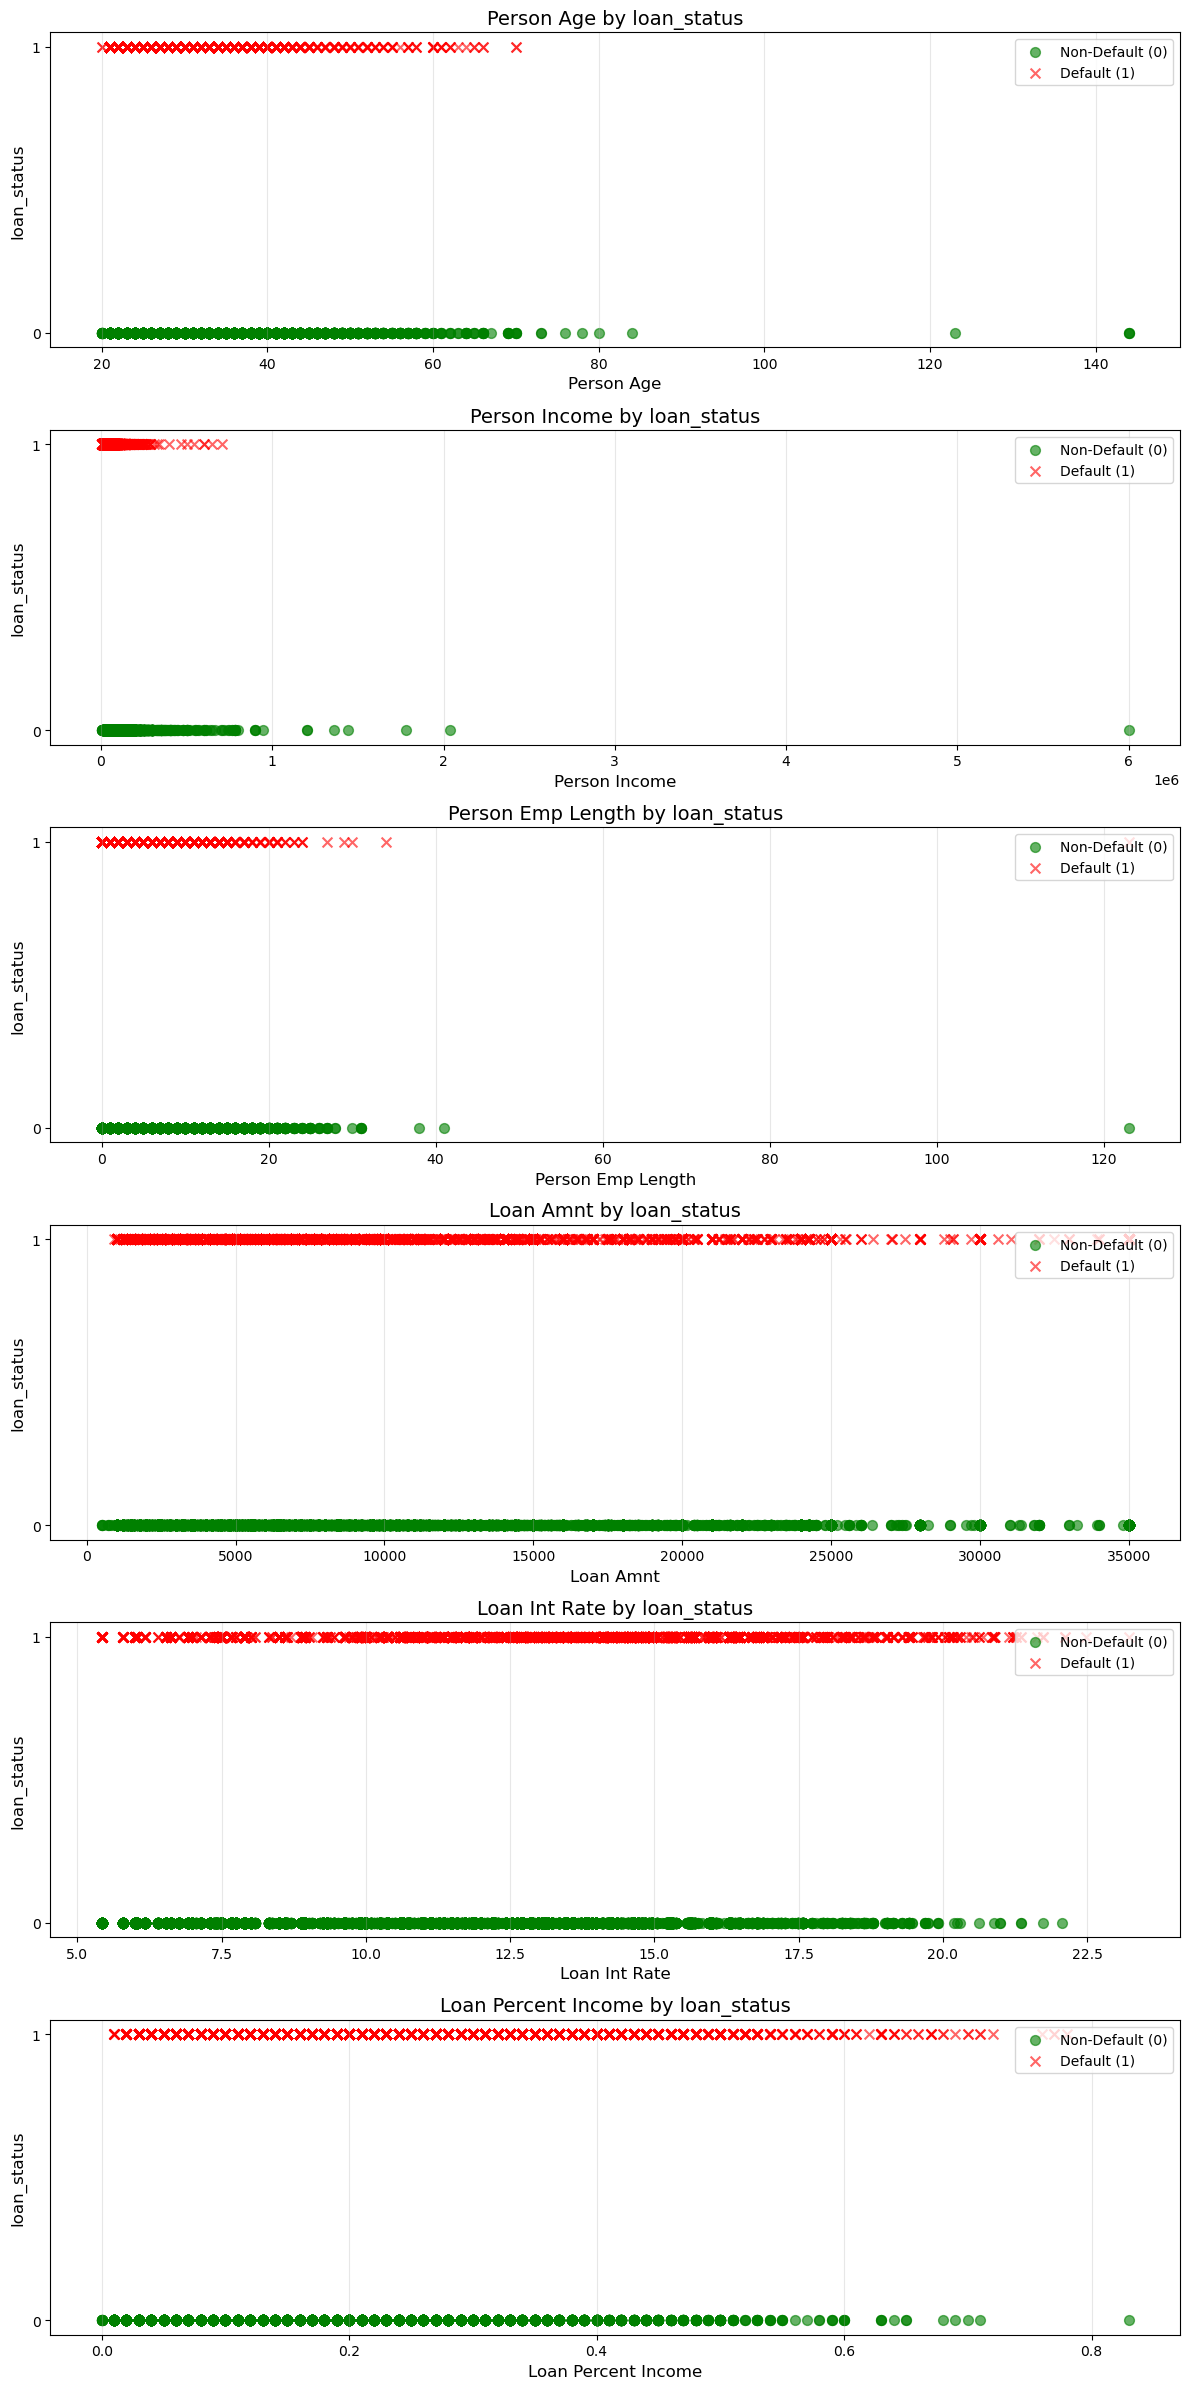

In [9]:

target_values = sorted(df[target_col].unique())
print(f"Target variable '{target_col}' has {len(target_values)} unique values: {target_values}")

fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(12, 4 * len(numerical_cols)))

if len(numerical_cols) == 1:
    axes = [axes]

styles = {
    0: {'marker': 'o', 'color': 'green', 'label': 'Non-Default (0)'},
    1: {'marker': 'x', 'color': 'red', 'label': 'Default (1)'}
}

for ax_idx, col in enumerate(numerical_cols):
    ax = axes[ax_idx]
    
    for target_val in target_values:
        df_subset = df.loc[df[target_col] == target_val]
        
        if len(df_subset) > 0:
            style = styles.get(target_val, {
                'marker': 'o',
                'color': f'C{target_val}',
                'label': f'{target_col}={target_val}'
            })
            
            y_level = target_val * 0.1  
            
            ax.scatter(df_subset[col], 
                      np.full(len(df_subset), y_level),
                      marker=style['marker'],
                      color=style['color'],
                      alpha=0.6,
                      s=50,
                      label=style['label'])
    
    ax.set_xlabel(col.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel(target_col, fontsize=12)
    
    ax.set_yticks([v * 0.1 for v in target_values])
    ax.set_yticklabels([f'{v}' for v in target_values])
    
    ax.grid(True, alpha=0.3, axis='x')
    ax.legend(loc='upper right')
    
    ax.set_title(f'{col.replace("_", " ").title()} by {target_col}', fontsize=14)

plt.tight_layout()
plt.show()

Multivariate Analysis

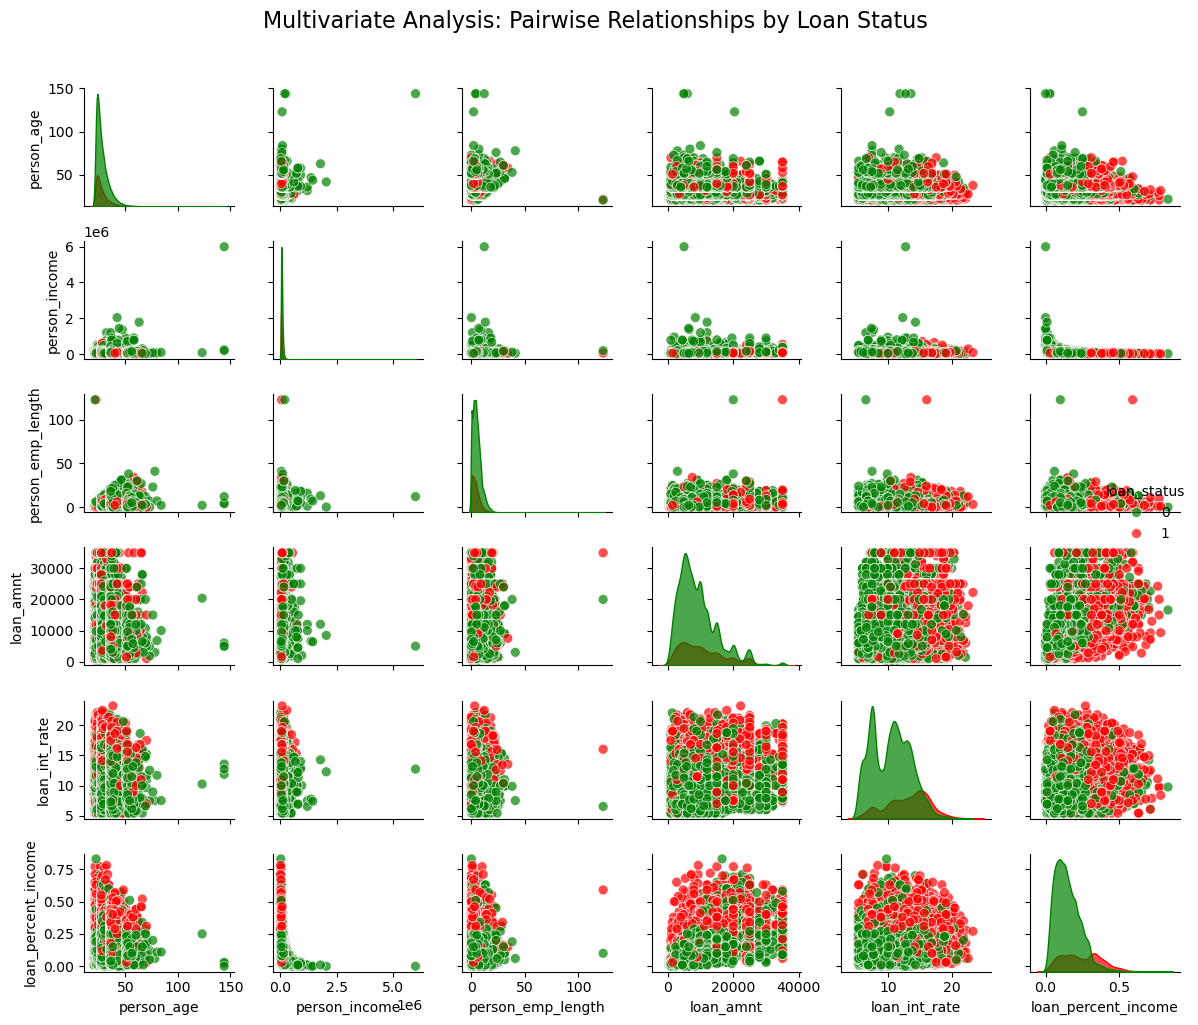

In [10]:
pairplot = sns.pairplot(df[numerical_cols + ['loan_status']], 
                        hue='loan_status',
                        diag_kind='kde',  
                        palette={0: 'green', 1: 'red'},
                        plot_kws={'alpha': 0.7, 's': 50, 'edgecolor': 'w'},
                        diag_kws={'alpha': 0.7, 'fill': True})

pairplot.fig.suptitle('Multivariate Analysis: Pairwise Relationships by Loan Status', 
                     fontsize=16, y=1.02)
pairplot.fig.set_size_inches(12, 10)  
plt.tight_layout()
plt.show()

In [11]:
def select_model_based_on_eda(df, target='loan_status'):
    """
    Select model based on patterns observed in EDA
    """
    
    # Analyze your EDA findings
    print("=" * 60)
    print("MODEL SELECTION BASED ON EDA FINDINGS")
    print("=" * 60)
    
    # 1. Check target distribution from univariate analysis
    target_dist = df[target].value_counts(normalize=True)
    imbalance_ratio = target_dist.iloc[0] / target_dist.iloc[1]
    
    print(f"\n1. Target Distribution Analysis:")
    print(f"   Class ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 4:
        print("   ⚠️  Highly imbalanced -> Use ensemble methods with class weighting")
        model_recommendation = "XGBoost or RandomForest with class_weight='balanced'"
    else:
        print("   ✓ Balanced enough -> Most algorithms will work")
        model_recommendation = "LogisticRegression or RandomForest"
    
    # 2. Check feature types from univariate analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\n2. Feature Type Analysis:")
    print(f"   Numerical features: {len(numeric_cols)}")
    print(f"   Categorical features: {len(categorical_cols)}")
    
    if len(categorical_cols) > 3:
        print("   ⚠️  Many categorical features -> Use tree-based models")
        model_recommendation = "RandomForest, XGBoost, or CatBoost"
    elif len(categorical_cols) == 0:
        print("   ✓ All numerical -> Linear models may work well")
    
    # 3. Check relationships from bivariate/multivariate analysis
    print(f"\n3. Relationship Analysis (from your plots):")
    
    # Assuming you observed these patterns:
    print("   Based on your scatter plots, check for:")
    print("   - Linear relationships? (age vs income)")
    print("   - Non-linear patterns? (income distribution)")
    print("   - Clear separations between classes?")
    
    # Ask yourself these questions:
    linear_relationships = input("   Did you see clear linear patterns? (y/n): ").lower()
    non_linear = input("   Did you see non-linear patterns? (y/n): ").lower()
    clear_separation = input("   Clear separation between default/non-default? (y/n): ").lower()
    
    if linear_relationships == 'y' and non_linear == 'n':
        print("   ✓ Linear patterns dominant -> Logistic Regression")
        model_recommendation = "LogisticRegression with regularization"
    elif non_linear == 'y':
        print("   ⚠️  Non-linear patterns -> Tree-based or SVM with RBF kernel")
        model_recommendation = "RandomForest, XGBoost, or SVM(rbf)"
    
    if clear_separation == 'y':
        print("   ✓ Clear separation -> Simpler models may suffice")
    else:
        print("   ⚠️  Overlapping classes -> Need powerful discriminative models")
        model_recommendation = "XGBoost or Neural Network"
    
    # 4. Check outliers from univariate analysis
    print(f"\n4. Outlier Analysis:")
    # Calculate outlier ratio for numerical columns
    outlier_cols = []
    for col in numeric_cols:
        if col != target:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outlier_ratio = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).mean()
            if outlier_ratio > 0.05:  # More than 5% outliers
                outlier_cols.append(col)
    
    if outlier_cols:
        print(f"   ⚠️  Outliers detected in: {outlier_cols}")
        print("   -> Use robust models (Tree-based, SVM)")
        model_recommendation = "RandomForest or SVM"
    else:
        print("   ✓ Minimal outliers -> Linear models OK")
    
    # 5. Check multicollinearity from multivariate analysis
    print(f"\n5. Multicollinearity Analysis:")
    if len(numeric_cols) > 1:
        corr_matrix = df[numeric_cols].corr().abs()
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > 0.8:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        
        if high_corr_pairs:
            print(f"   ⚠️  High correlation between: {high_corr_pairs[:3]}")
            print("   -> Use regularization or tree-based models")
            model_recommendation = "Lasso Regression or RandomForest"
        else:
            print("   ✓ Low multicollinearity")
    
    print(f"\n" + "=" * 60)
    print(f"RECOMMENDED MODEL: {model_recommendation}")
    print("=" * 60)
    
    return model_recommendation

# Run the analysis
recommended_model = select_model_based_on_eda(df)

MODEL SELECTION BASED ON EDA FINDINGS

1. Target Distribution Analysis:
   Class ratio: 3.56:1
   ✓ Balanced enough -> Most algorithms will work

2. Feature Type Analysis:
   Numerical features: 8
   Categorical features: 4
   ⚠️  Many categorical features -> Use tree-based models

3. Relationship Analysis (from your plots):
   Based on your scatter plots, check for:
   - Linear relationships? (age vs income)
   - Non-linear patterns? (income distribution)
   - Clear separations between classes?
   ✓ Clear separation -> Simpler models may suffice

4. Outlier Analysis:
   ⚠️  Outliers detected in: ['loan_amnt']
   -> Use robust models (Tree-based, SVM)

5. Multicollinearity Analysis:
   ⚠️  High correlation between: [('person_age', 'cb_person_cred_hist_length')]
   -> Use regularization or tree-based models

RECOMMENDED MODEL: Lasso Regression or RandomForest


Train Test Split

In [12]:
X = df[numerical_cols + categorical_cols]

y = df[target_col]

df_full_train, df_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=42)

In [13]:
X_train = pd.get_dummies(df_train)

X_val = pd.get_dummies(df_val)

X_test = pd.get_dummies(df_test)

X_full_train = pd.get_dummies(df_full_train)

Train XGBoost

In [14]:
model = XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [15]:
y_proba = model.predict_proba(X_train)[:, 1]

roc_auc_score(y_train, y_proba)

np.float64(0.9933623483156431)

In [16]:
y_proba = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_proba)

np.float64(0.9473474718785577)

In [17]:
y_pred = model.predict(X_val)

accuracy_score(y_val, y_pred)

0.9343288647547938

Fine Tune Logistic Regression

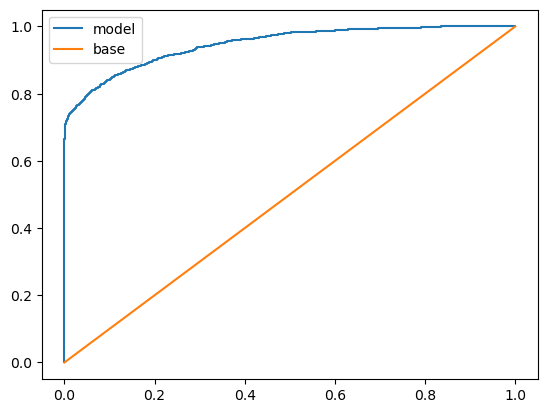

In [18]:
fpr, tpr, thresh = roc_curve(y_val, y_proba)

plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='base')
plt.legend()

In [19]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4595
           1       0.95      0.74      0.83      1298

    accuracy                           0.93      5893
   macro avg       0.94      0.86      0.90      5893
weighted avg       0.94      0.93      0.93      5893



In [20]:
print(model.get_booster().get_score(importance_type='weight'))

{'person_age': 362.0, 'person_income': 714.0, 'person_emp_length': 336.0, 'loan_amnt': 367.0, 'loan_int_rate': 580.0, 'loan_percent_income': 286.0, 'person_home_ownership_MORTGAGE': 51.0, 'person_home_ownership_OTHER': 6.0, 'person_home_ownership_OWN': 45.0, 'person_home_ownership_RENT': 74.0, 'loan_intent_DEBTCONSOLIDATION': 56.0, 'loan_intent_EDUCATION': 36.0, 'loan_intent_HOMEIMPROVEMENT': 61.0, 'loan_intent_MEDICAL': 72.0, 'loan_intent_PERSONAL': 37.0, 'loan_intent_VENTURE': 36.0, 'loan_grade_A': 7.0, 'loan_grade_B': 34.0, 'loan_grade_C': 62.0, 'loan_grade_D': 53.0, 'loan_grade_E': 13.0, 'loan_grade_F': 6.0, 'loan_grade_G': 12.0}


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

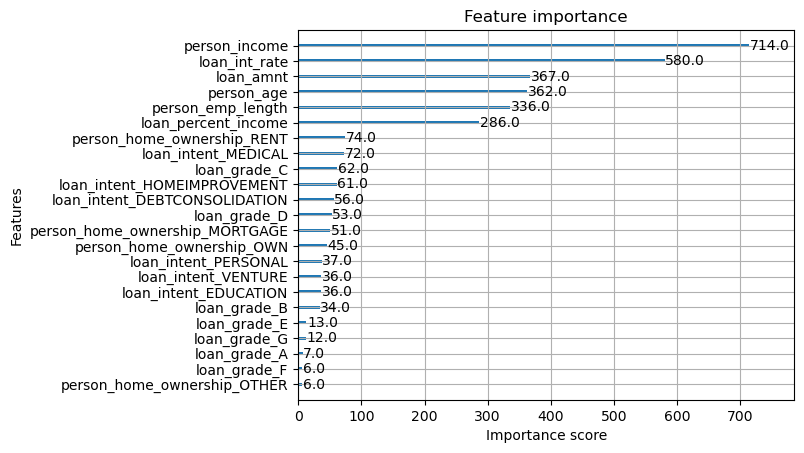

In [21]:
xgb.plot_importance(model.get_booster(), importance_type='weight')

Cross-validation

In [22]:
n_folds = 5
early_stopping = 10

params = {'objective': 'binary:logistic', 'seed': 123, 'eval_metric': 'auc'}

DTrain = xgb.DMatrix(X_train, label = y_train)

cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.903603       0.002122       0.896595      0.007892
1        0.912921       0.002179       0.905677      0.008091
2        0.918537       0.001904       0.911205      0.006854
3        0.923702       0.001564       0.914890      0.006009
4        0.927678       0.001627       0.917248      0.006197


In [23]:
model = XGBClassifier(learning_rate = 0.1, max_depth = 7)

cv_scores = cross_val_score(model, X_train, np.ravel(y_train), cv = 4)

print(cv_scores)

print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

[0.92714932 0.93846154 0.93257919 0.93573207]
Average accuracy: 0.93 (+/- 0.01)


Train Final Model


In [24]:
model = XGBClassifier(learning_rate = 0.1, max_depth = 7)

model.fit(X_full_train, y_full_train)

y_proba = model.predict(X_test)

roc_auc_score(y_test, y_proba)

np.float64(0.8592767767517399)

In [25]:
print(classification_report(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4585
           1       0.97      0.72      0.83      1308

    accuracy                           0.93      5893
   macro avg       0.95      0.86      0.90      5893
weighted avg       0.94      0.93      0.93      5893



In [26]:
output_file = 'model/model_lr=0.1_md=7'

with open(output_file, 'wb') as f_out:

    pickle.dump(model, f_out)